In [1]:
import psycopg2
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
!pip install -q git+https://github.com/tensorflow/docs
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
conn = psycopg2.connect(host="postgres", port = 5432, database="production", user="user", password="password")

In [3]:
employees = pd.read_sql_query("select * from employees", conn)

In [4]:
employees.head()

,id,code,first_name,last_name,middle_name,hire_date,user_id,color,compensation_type,last_modified
0,50,1297,Austin,Plewa,,2018-04-16,2,#1f78b4,None,2020-07-09 14:59:03.649391
1,51,4791,Brandon,Bauer,,2012-10-28,3,#33a02c,None,2020-07-09 14:59:03.661626
2,53,6868,Brandon,Plewa,,2014-09-18,4,#ff7f00,None,2020-07-09 14:59:03.673221
3,54,2580,Carlton,Aures,,2019-05-20,5,#6a3d9a,None,2020-07-09 14:59:03.685620
4,55,1878,Chris,Lowe,,2019-03-26,6,#1f78b4,None,2020-07-09 14:59:03.699674


In [5]:
employees_map = dict(zip(employees['id'], employees['first_name'].str.lower().str[0] + employees['last_name'].str.lower()))

In [6]:
dataset = pd.read_sql_query('''
    select
        employee_id,
        extract(epoch from cast(date_start as time)) as date_start,
        extract(epoch from duration) as duration
    from timeclock_shifts_view
    where date_stop is not null
    order by date_stop desc, date_start desc
''', conn)

In [7]:
dataset['employee_id'] = dataset['employee_id'].map(employees_map)

In [8]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,date_start,duration,ajolls,aplewa,arichardson,bbauer,bhall,bplewa,caures,clowe,...,mdollas-halbach,nhaefner,plewandowski,proberts,rhurd,rmawhinney,rsteiner,szagrobelny,tharling,thorn
4009,37620.0,30754.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4010,42900.0,18360.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4011,32940.0,31680.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4012,32100.0,30629.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4013,41520.0,19757.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [9]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print(train_dataset.shape, test_dataset.shape)

(3211, 31) (803, 31)


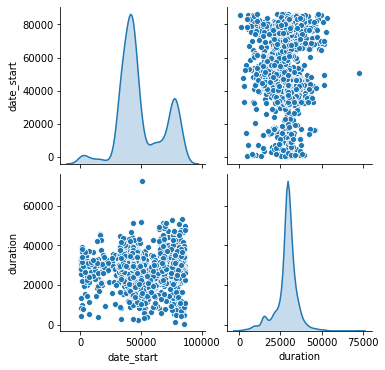

In [10]:
sns.pairplot(train_dataset[["date_start", "duration"]], diag_kind="kde")

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("duration")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
date_start,3211.0,49602.642790,18479.893210,104.0,38180.0,43378.0,65528.0,86322.0
ajolls,3211.0,0.027717,0.164187,0.0,0.0,0.0,0.0,1.0
aplewa,3211.0,0.057303,0.232457,0.0,0.0,0.0,0.0,1.0
arichardson,3211.0,0.015571,0.123830,0.0,0.0,0.0,0.0,1.0
bbauer,3211.0,0.056992,0.231863,0.0,0.0,0.0,0.0,1.0
bhall,3211.0,0.006851,0.082502,0.0,0.0,0.0,0.0,1.0
bplewa,3211.0,0.056992,0.231863,0.0,0.0,0.0,0.0,1.0
caures,3211.0,0.009654,0.097796,0.0,0.0,0.0,0.0,1.0
clowe,3211.0,0.037060,0.188939,0.0,0.0,0.0,0.0,1.0
dgasiewicz,3211.0,0.053566,0.225194,0.0,0.0,0.0,0.0,1.0


In [12]:
train_labels = train_dataset.pop('duration') # used to identify predicted value
test_labels = test_dataset.pop('duration')

In [13]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [14]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1984      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,209
Trainable params: 6,209
Non-trainable params: 0
_________________________________________________________________


In [15]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:867090368.0000,  mae:28720.6582,  mse:867090368.0000,  val_loss:885155392.0000,  val_mae:29107.6680,  val_mse:885155392.0000,  
....................................................................................................
Epoch: 100, loss:26601844.0000,  mae:3452.3914,  mse:26601844.0000,  val_loss:26330330.0000,  val_mae:3408.2100,  val_mse:26330330.0000,  
....................................................................................................
Epoch: 200, loss:25890006.0000,  mae:3414.1772,  mse:25890006.0000,  val_loss:26042264.0000,  val_mae:3394.1541,  val_mse:26042264.0000,  
....................................................................................................
Epoch: 300, loss:25357278.0000,  mae:3377.2410,  mse:25357278.0000,  val_loss:25995114.0000,  val_mae:3392.3530,  val_mse:25995114.0000,  
....................................................................................................
Epoch: 400, loss:24889182.0000,  ma

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,23226362.0,3209.944824,23226362.0,24520926.0,3258.609131,24520926.0,995
996,23231276.0,3217.696777,23231276.0,24532612.0,3256.650391,24532612.0,996
997,23226908.0,3211.587158,23226908.0,24517408.0,3252.612793,24517408.0,997
998,23218828.0,3206.879150,23218828.0,24558338.0,3240.963135,24558338.0,998
999,23221004.0,3214.340332,23221004.0,24533736.0,3241.706543,24533736.0,999


Text(0, 0.5, 'MAE [MPG]')

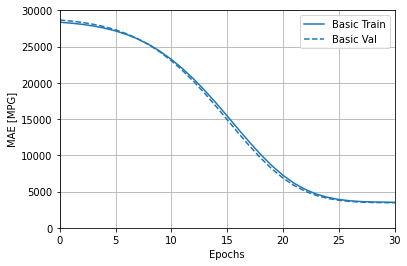

In [17]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 30000])
plt.xlim([0, 30])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

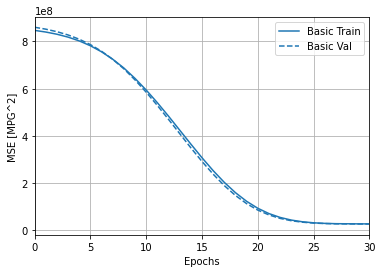

In [18]:
plotter.plot({'Basic': history}, metric = "mse")
plt.xlim([0, 30])
plt.ylabel('MSE [MPG^2]')

In [19]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} Seconds".format(mae))

26/26 - 0s - loss: 28120770.0000 - mae: 3414.8191 - mse: 28120770.0000
Testing set Mean Abs Error: 3414.82 Seconds


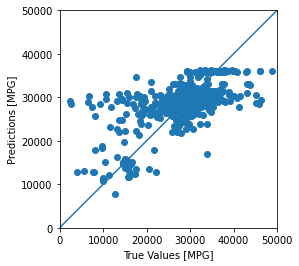

In [32]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

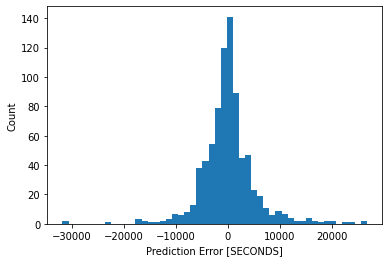

In [31]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [SECONDS]")
_ = plt.ylabel("Count")

In [22]:
test_date_start = datetime(2020, 2, 5, 12)
def get_seconds(dt):
    t = dt.time()
    s = (t.hour * 60 + t.minute) * 60 + t.second
    return s

#employee_id = 57

def make_prediction(dt, employee_id):
    test = pd.DataFrame(columns=normed_test_data.columns)
    val = pd.DataFrame([{'employee_id': employee_id, 'date_start': get_seconds(dt)}])
    val['employee_id'] = val['employee_id'].map(employees_map)
    val = pd.get_dummies(val, prefix='', prefix_sep='')

    for col in normed_test_data.columns:
        if col not in val:
            val[col] = 0

    val = val[[c for c in normed_test_data.columns]]
    val = norm(val)

    return model.predict(val).flatten()
employee_id = 80

prediction = make_prediction(test_date_start, employee_id)
'when starting at {}: {:.3} hours'.format(test_date_start, prediction[0] / 3600)

'when starting at 2020-02-05 12:00:00: 4.25 hours'

In [29]:
target_employee = employees.loc[employees['first_name'] == 'Terence'].iloc[0]
target_employee

id                                           74
code                                       2010
first_name                              Terence
last_name                                  Horn
middle_name                                   J
hire_date                            2017-06-28
user_id                                      22
color                                   #6a3d9a
compensation_type                          None
last_modified        2020-07-09 14:59:03.896319
Name: 20, dtype: object

Text(0, 0.5, 'Length of shift (hours)')

<Figure size 432x288 with 0 Axes>

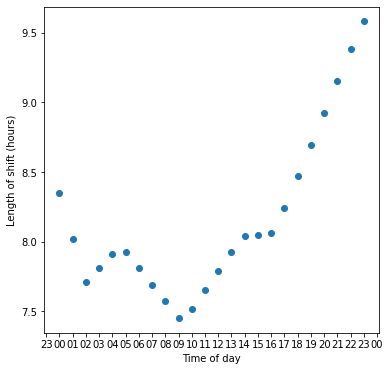

In [30]:
plt.clf()
plt.figure(figsize=(6,6))
base = datetime(2020, 1, 1)
xx = np.array([base + i * timedelta(hours=1) for i in range(24)])
f = lambda dt: make_prediction(dt, target_employee['id'])
yy = np.vectorize(f)(xx) / 3600

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.scatter(xx, yy)
plt.xlabel('Time of day')
plt.ylabel('Length of shift (hours)')